In [1]:
import sys
sys.path.append('./pyuid3')

In [2]:
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
from anchor import utils
from anchor import anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, MinMaxScaler
import shap
import lime
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from pyuid3.entropy_evaluator import *
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
dataset_size = 1000
neighborhood_size=100

# Create synthetic classification dataset

# Make moons

In [4]:
X,y = sklearn.datasets.make_moons(n_samples=dataset_size,  noise=0.25, random_state=0)#factor=0.5
#Xa,ya = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                    #random_state=0, center_box=(-0.8,0))
#Xb,yb = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                   # random_state=0, center_box=(-3.5,3.3))

#X = np.vstack((X,Xa,Xb))
#y = np.hstack((y,ya,yb+1))

Xdf = pd.DataFrame(X, columns=['x1','x2'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['x1','x2']
X_test.columns = ['x1','x2']

<AxesSubplot:xlabel='x1', ylabel='x2'>

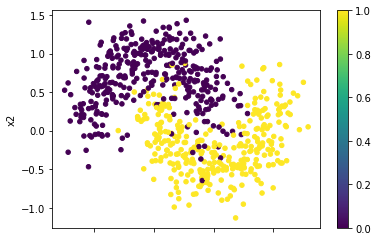

In [6]:
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis')

In [7]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='rbf',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9181818181818182
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       153
           1       0.91      0.94      0.93       177

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



In [8]:
from sklearn.linear_model import LogisticRegression
xclf = RandomForestClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
xclf.fit(X_train, y_train)
lr_preds = xclf.predict(X_test)

In [9]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.9333333333333333
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       153
           1       0.94      0.94      0.94       177

    accuracy                           0.93       330
   macro avg       0.93      0.93      0.93       330
weighted avg       0.93      0.93      0.93       330



<AxesSubplot:xlabel='x1', ylabel='x2'>

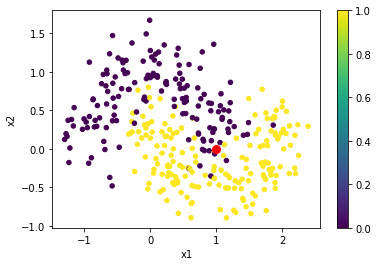

In [10]:
fig, ax = plt.subplots()
point = [1.0,0.0]
ax.plot(point[0], point[1], 'or', markersize=8)
X_test.plot(kind='scatter',x='x1', y='x2', c=y_test, colormap='viridis', ax=ax)

In [11]:
X_test_appended = X_test.append(pd.DataFrame([point], columns=['x1','x2']), ignore_index=True)
y_test_appended = np.concatenate([y_test,[1]])

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


## Decision Boundaries

X does not have valid feature names, but SVC was fitted with feature names


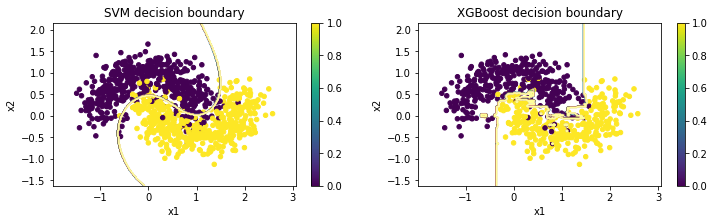

In [12]:

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
Xdf.plot(kind='scatter',x='x1', y='x2',style='.', c=y, colormap='viridis',ax=ax[0])

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis',ax=ax[1])
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')
fig.savefig('dataset.png')

## Confidence plots

X does not have valid feature names, but SVC was fitted with feature names


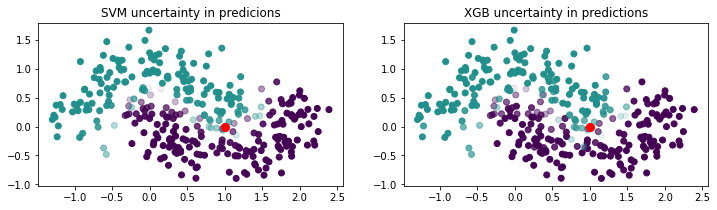

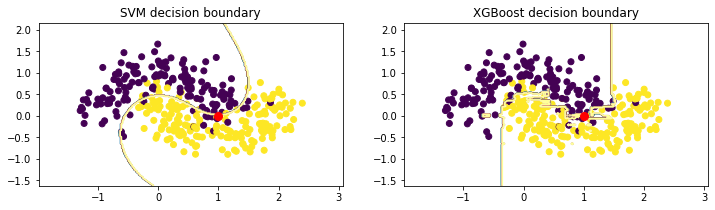

In [13]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = svc.predict_proba(X_test_appended)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

y_test_proba_xg = xclf.predict_proba(X_test_appended)
confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

X_test_1 = X_test_appended.iloc[y_test_appended==1]
X_test_2 = X_test_appended.iloc[y_test_appended==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_svc.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions')


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_xgb.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_xgb.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='XGB uncertainty in predictions')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)


fig.savefig('uncertainty-point.png')

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
fig.savefig('decbound-point.png')
plt.show()

## LUX explanations

In [14]:
from lux.lux import LUX

In [15]:
point = [0,1]
clf = xclf

lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=0.2,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
X_train_sample, _ = lux.create_sample_bb(X_train, y_train,np.array([point]),X_importances = None, exclude_neighbourhood=False, use_parity=True, inverse_sampling=True, class_names=[0,1],density_sampling=True, radius_sampling=True, representative='centroid')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


Setting radius to [1.24527375]
Farthest point: [2.75020783]


In [16]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE,ADASYN,SVMSMOTE

In [17]:
def outliers(data,multiplier=1.5):
    # finding the 1st quartile
    q1 = np.quantile(data, 0.25)

    # finding the 3rd quartile
    q3 = np.quantile(data, 0.75)

    # finding the iqr region
    iqr = q3-q1

    # finding upper and lower whiskers
    upper_bound = q3+(multiplier*iqr)
    lower_bound = q1-(multiplier*iqr)
    return (iqr, upper_bound, lower_bound)

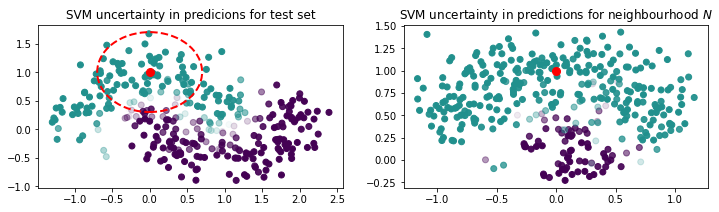

In [18]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = clf.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))


y_test_proba_o = clf.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)

fig.savefig('neighbourhood.png')

In [19]:
import warnings
warnings.filterwarnings('ignore')
#for i in np.arange(10):
for c in np.unique(y_train):
    X_train_input_c  = X_train_sample.loc[clf.predict(X_train_sample) ==c]
    prediction_certainty = np.max(clf.predict_proba(X_train_input_c), axis=1)
    #_,_,confidence_threshold = outliers(prediction_certainty,multiplier=1.5)
    confidence_threshold = np.mean(prediction_certainty)-np.std(prediction_certainty)
    X_train_input = X_train_input_c[prediction_certainty<confidence_threshold]
    predictions = clf.predict(X_train_sample)
    unique, counts = np.unique(predictions, return_counts=True)
    try:
        sm = BorderlineSMOTE(random_state=42)#,k_neighbors=min(5,min(counts)))#,m_neighbors=min(min(counts),10))
        X_train_input = pd.concat([X_train_input, X_train_sample[clf.predict(X_train_sample) !=c]])
        X_input_c,_ = sm.fit_resample(X_train_input, clf.predict(X_train_input))
        concatdf = pd.concat((X_input_c, X_train_sample))
        X_train_sample =concatdf.loc[~concatdf.duplicated()]
    except:
        print('Error')
        pass


## Neighbourhood plotting

In [20]:
sm = SMOTE(random_state=42)
X_train_sample,_ = sm.fit_resample(X_train_sample, clf.predict(X_train_sample))

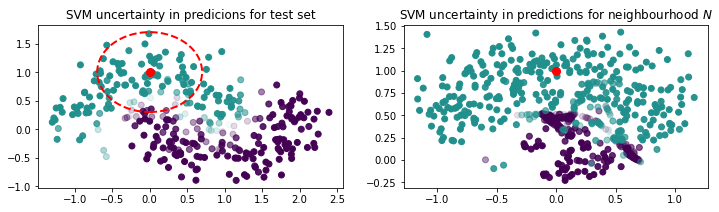

In [21]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = clf.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))


y_test_proba_o = clf.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)

fig.savefig('neighbourhood2.png')

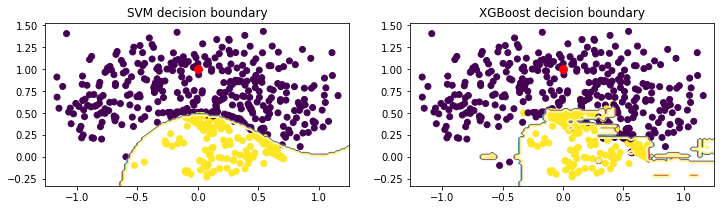

In [22]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X_train_sample.values[:, 0].min() - 0.1, X_train_sample.values[:, 0].max() + 0.1
y_min, y_max = X_train_sample.values[:, 1].min() - 0.1, X_train_sample.values[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_train_sample['x1'], X_train_sample['x2'], c=svc.predict(X_train_sample), cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_train_sample['x1'], X_train_sample['x2'], c=clf.predict(X_train_sample), cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
plt.show()

In [23]:
X_train_sample.shape

(762, 2)

In [24]:
clfgb = xgb.XGBClassifier(eval_metric='error')
clfgb.fit(X_train,y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
explainer = shap.Explainer(clfgb, X_train_sample,model_output='probability')
shap_values = explainer.shap_values(X_train_sample,check_additivity=True)

In [26]:
shap_values[0]
explainer.expected_value

0.42726185979537507

In [27]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf, X_train_sample,model_output='probability')
shap_values = explainer.shap_values(X_train_sample,check_additivity=True)

In [28]:
uarff=LUX.generate_uarff(X_train_sample,clf.predict_proba(X_train_sample), X_importances=None,class_names=[0,1])
data = Data.parse_uarff_from_string(uarff)

In [29]:
datadf = data.to_dataframe()
shap_dict={}
expected_dict={}
expected_values = explainer.expected_value
for i,v in enumerate(shap_values):
    shap_dict[str(i)] = pd.DataFrame(v, columns = datadf.columns[:-1])
    expected_dict[str(i)] = expected_values[i]

data = data.set_importances(pd.concat(shap_dict,axis=1), expected_values = expected_dict)

In [30]:
data.instances[-1].get_reading_for_attribute('x2').get_most_probable().get_importances()

{'0': 0.04469999900087714, '1': -0.04469999900087714}

In [31]:
def get_maximum_label(shapdict):
            return max(shapdict, key=shapdict.get)
        
labels = [get_maximum_label(i.get_reading_for_attribute('x2').get_most_probable().get_importances()) for i in data.instances]

In [32]:
true_labels = [i.get_reading_for_attribute(data.get_class_attribute().get_name()).get_most_probable().get_name() for i in data.instances]

In [33]:
len(true_labels)

762

In [34]:
len(labels)

762

In [35]:
sum(np.array(labels)==np.array(true_labels))/len(labels)

0.8989501312335958

In [36]:
tlabels = clf.predict(datadf.iloc[:,:-1])

In [37]:
ilabels = [int(i) for i in labels]

In [38]:
(tlabels==ilabels).sum()/len(labels)

0.8989501312335958

In [39]:
idx_error_x1 = datadf.iloc[np.where(tlabels!=ilabels)].index 
datadf.loc[:,'x2_shap_error'] =datadf['class']
datadf.loc[idx_error_x1,'x2_shap_error'] = 2
datadf = datadf.fillna(0)

<AxesSubplot:xlabel='x1', ylabel='x2'>

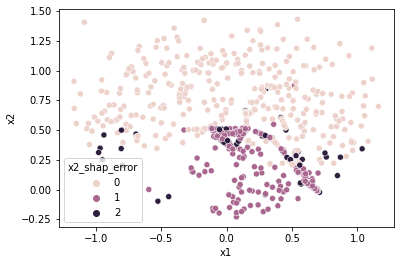

In [40]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x2_shap_error')

In [41]:
labelsx1 = [get_maximum_label(i.get_reading_for_attribute('x1').get_most_probable().get_importances()) for i in data.instances]

In [42]:
ilabelsx1 = [int(i) for i in labelsx1]
(tlabels==ilabelsx1).sum()/len(labels)

0.7007874015748031

In [43]:
idx_error_x1 = datadf.iloc[np.where(tlabels!=ilabelsx1)].index 
datadf.loc[:,'x1_shap_error'] =datadf['class']
datadf.loc[:,'x1_shap'] =ilabelsx1
datadf.loc[idx_error_x1,'x1_shap_error'] = 2
datadf = datadf.fillna(0)

<AxesSubplot:xlabel='x1', ylabel='x2'>

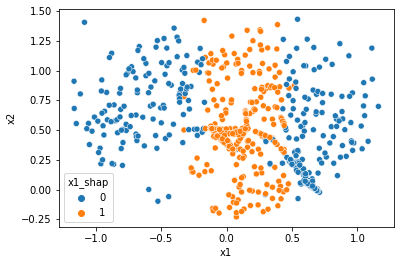

In [44]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1_shap')

<AxesSubplot:xlabel='x1', ylabel='x2'>

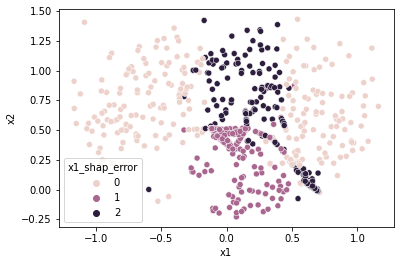

In [45]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1_shap_error')

<AxesSubplot:xlabel='x1', ylabel='x2'>

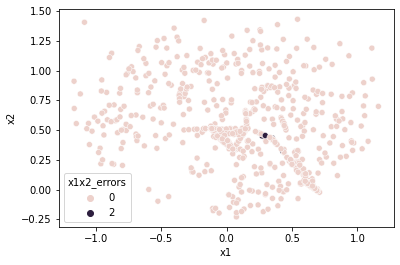

In [46]:
datadf['x1x2_errors']=0
datadf.loc[(datadf['x1_shap_error']==2) & (datadf['x2_shap_error']==2),'x1x2_errors'] =2
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1x2_errors')

In [47]:
stats = data.calculate_statistics(data.get_attribute_of_name('x1'))

In [48]:
stats.get_avg_abs_importance()

0.34780865364319374

In [49]:
stats = data.calculate_statistics(data.get_attribute_of_name('x2'))

In [50]:
stats.get_avg_abs_importance()

0.45271075103598113

In [55]:
import sys
sys.path.append('./EXPLAN')
from LORE import lore
from LORE.neighbor_generator import *

In [57]:
import explan
from utils import *
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import sklearn.datasets
import warnings
warnings.filterwarnings("ignore")


# Reading and preparing data set
path_data = './EXPLAN/datasets/'
dataset_name = 'compas-scores-two-years.csv'
dataset = prepare_compass_dataset(dataset_name, path_data)

# Splitting the data set into train and test sets
X, y = dataset['X'], dataset['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating black-box model
blackbox = GradientBoostingClassifier(random_state=42)
blackbox.fit(X_train, y_train)

# Selecting instance to explain
index = 10
instance2explain = X_test[index]

# EXPLAN hyper-parameters
N_samples = 3000
tau = 250

# # Explaining instance x using EXPLAN
# exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
#                                            blackbox,
#                                            dataset,
#                                            N_samples=N_samples,
#                                            tau=tau)

# # Reporting the results
# dfX2E = build_df2explain(blackbox, X_test, dataset).to_dict('records')
# dfx = dfX2E[index]
# print('x = %s' % dfx)

# print('e = %s' % exp_EXPLAN[1])
# print('Black-box prediction = %s' % info_EXPLAN['y_x_bb'])
# print('C4.5 Tree prediction = %s' % info_EXPLAN['y_x_dt'])



exp_LORE, info_LORE = lore.explain(0, X_test,
                                   dataset, blackbox,
                                   ng_function=genetic_neighborhood,
                                   discrete_use_probabilities=True,
                                   continuous_function_estimation=False,
                                   returns_infos=True, path=path_data,
                                   sep=';', log=True)


DO no like encoding


ValueError: y contains previously unseen labels: [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  51  52  53  54  55  56
  57  58  59  60  61  62  63  65  66  68  69  71  73  74  75  76  77  78
  80  81  82  83  84  86  87  90  91  92  95  97  98  99 100 103 105 106
 109 112 115 116 117 118 120 121 125 127 128 130 131 133 137 138 141 144
 149 151 152 155 156 160 167 169 170 174 178 181 185 186 188 190 194 198
 199 202 205 209 214 218 226 236 239 242 243 255 266 323 403 424 474 506
 749]

In [58]:
import explan
from utils import *
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import sklearn.datasets
import warnings
warnings.filterwarnings("ignore")
features = ['x1','x2']
# df = datadf[features+['class']]
# df['class'] = df['class'].astype(int)


X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)#factor=0.5
#Xa,ya = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                    #random_state=0, center_box=(-0.8,0))
#Xb,yb = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                   # random_state=0, center_box=(-3.5,3.3))

#X = np.vstack((X,Xa,Xb))
#y = np.hstack((y,ya,yb+1))
df = pd.DataFrame(X, columns=['x1','x2'])
df['class'] = y

In [59]:
from sklearn.preprocessing import LabelEncoder
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder=[]):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset
    

In [60]:
import os
import pickle
from sklearn.preprocessing import StandardScaler
directory = './data/numerical_only/balanced'


for num_and_cat in  os.listdir(directory):
    #(data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    break
(data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
features = [f'f_{i}' for i in range(0,data.shape[1])]
target = 'class'
df = pd.DataFrame(data,columns=features,dtype=float)
sc = StandardScaler()
df.loc[:]=sc.fit_transform(df)#normalize(df, axis=0)#sc.fit_transform(df)
df[target] = y

In [61]:
#myds = prepare_ds(df,discrete=[False,False])
myds = prepare_ds(df,discrete=[False]*len(features))
X, y = myds['X'], myds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Creating black-box model
blackbox = GradientBoostingClassifier(random_state=42)
blackbox.fit(X_train, y_train)

# Selecting instance to explain
index = 3
instance2explain = X_test[index]

# EXPLAN hyper-parameters
N_samples = 500
tau = 250

# Explaining instance x using EXPLAN
exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
                                           blackbox,
                                           myds,
                                           N_samples=N_samples,
                                           tau=tau)

# Reporting the results
dfX2E = build_df2explain(blackbox, X_test, myds).to_dict('records')
dfx = dfX2E[index]
print('x = %s' % dfx)
print('e = %s' % exp_EXPLAN[1])
print('Black-box prediction = %s' % info_EXPLAN['y_x_bb'])
print('C4.5 Tree prediction = %s' % info_EXPLAN['y_x_dt'])
#print(f'{class_name}, {columns}, {features_type}, {discrete}, {continuous}')

./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 16 class: 1 weight: 0 rows: 508\n + load time: 0.021741 secs (7.14 MiB/s, 23.36 K rows/s)\n + indexing ... done\n + total time: 0.028202 secs (5.5 MiB/s, 18.01 K rows/s)\nBuilding 1 tree(s) on 508 cases\n + tree(s) built\n + size: 7 depth: 2 nf: 3 time: 0.013961 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 2 nf: 3 time: 7e-06 secs\n'
x = {'f_0': -0.0504606262333807, 'f_1': 0.15620411807788268, 'f_2': -0.37565577524774, 'f_3': -0.5061018798357726, 'f_4': -0.7355891440855724, 'f_5': 0.04597147088870698, 'f_6': -0.2882016639553414, 'f_7': -0.14859364360838961, 'f_8': 0.44133409188932027, 'f_9': 0.7575730366346997, 'f_10': -0.618329934159594, 'f_11': -0.3753221962762177, 'f_12': 0.3365843252360459, 'f_13': -0.5335863160002843, 'f_14': -0.7608865116274218, 'f_15'

In [75]:
import explan
from utils import *
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import sklearn.datasets

def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder=[]):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset

X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)
XX=np.concatenate((X,X,X,X),axis=1)
features = [f'f_{i}' for i in range(0,XX.shape[1])]
df = pd.DataFrame(XX, columns=features)
df['class'] = y

myds = prepare_ds(df,discrete=[False]*len(features))
X, y = myds['X'], myds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Creating black-box model
blackbox = GradientBoostingClassifier(random_state=42)
blackbox.fit(X_train, y_train)

# Selecting instance to explain
index = 0
instance2explain = X_test[index]

# EXPLAN hyper-parameters
N_samples = 3000
tau = 500

# Explaining instance x using EXPLAN
exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
                                           blackbox,
                                           myds,
                                           N_samples=N_samples,
                                           tau=tau)

# Reporting the results
dfX2E = build_df2explain(blackbox, X_test, myds).to_dict('records')
dfx = dfX2E[index]
print('x = %s' % dfx)
print('e = %s' % exp_EXPLAN[1])
print('Black-box prediction = %s' % info_EXPLAN['y_x_bb'])
print('C4.5 Tree prediction = %s' % info_EXPLAN['y_x_dt'])




exp_LORE, info_LORE = lore.explain(1, myds['X'],
                                   myds, blackbox,
                                   ng_function=genetic_neighborhood,
                                   discrete_use_probabilities=True,
                                   continuous_function_estimation=False,
                                   returns_infos=True, path=path_data,
                                   sep=';', log=True)


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 8 class: 1 weight: 0 rows: 1220\n + load time: 0.016057 secs (11.49 MiB/s, 75.97 K rows/s)\n + indexing ... done\n + total time: 0.020658 secs (8.93 MiB/s, 59.05 K rows/s)\nBuilding 1 tree(s) on 1220 cases\n + tree(s) built\n + size: 5 depth: 2 nf: 2 time: 0.006368 secs\nPruning tree using training set\n + tree pruned\n + size: 5 depth: 2 nf: 2 time: 7e-06 secs\n'
x = {'f_0': 0.5551347579285367, 'f_1': -0.38115448623228965, 'f_2': 0.5551347579285367, 'f_3': -0.38115448623228965, 'f_4': 0.5551347579285367, 'f_5': -0.38115448623228965, 'f_6': 0.5551347579285367, 'f_7': -0.38115448623228965, 'class': 1}
e = {'f_2': '<=0.625147'}
Black-box prediction = 1
C4.5 Tree prediction = 1
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/datasets/dataset.data -fm ./EXPLAN/datasets/dataset.names -sep ; -d ./EXPLAN/da

In [66]:
exp_LORE

([{'class': 1}, {'x2': '<=0.453923', 'x1': '>-0.404030'}, [572.0, 39.7]],
 [{'x2': '>0.453923'}, {'x1': '<=-0.40403'}])

In [ ]:
list(exp_EXPLAN[1].keys())

In [ ]:
exp_EXPLAN

In [ ]:
#pyyadt.predict(info_EXPLAN['C'], df.to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])

In [ ]:
sum(info_EXPLAN['y_X_bb']==info_EXPLAN['y_X_dt'])/len(info_EXPLAN['y_X_dt'])

In [ ]:
#build_df2explain(blackbox, X_test, myds)

In [ ]:



columns = myds['columns']
features_type = myds['features_type']
discrete = myds['discrete']
label_encoder = myds['label_encoder']

y = blackbox.predict(X_test)
yX = np.concatenate((X_test,y.reshape(-1, 1)), axis=1)
data = list()
for i, col in enumerate(columns):
    data_col = yX[:, i]
    data_col = data_col.astype(int) if col in discrete else data_col
    data_col = data_col.astype(int) if features_type[col] == 'integer' else data_col
    data.append(data_col)
# data = map(list, map(None, *data))
data = [[d[i] for d in data] for i in range(0, len(data[0]))]
dfZ = pd.DataFrame(data=data, columns=columns)
#dfZ = label_decode(dfZ, discrete, label_encoder)

In [ ]:
for i, col in enumerate(columns):
    print( features_type[col])

In [ ]:
dfZ